<a href="https://colab.research.google.com/github/Lucy-Moctezuma/Machine-Learning-Projects-for-SFSU/blob/main/E.%20Coli%20Machine%20Learning%20Project/1_Introduction_to_ML_for_AMR_Prediction_for_E_Coli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


***Click on the button that reads “Open in Colab” to open this code in Google Colab. Once open in Google Colab, you can make a copy of the notebook in your personal drive and run the code by clicking a little triangle/arrow to the left of each code block.***

# **Welcome to Antibiotic Resistance Prediction for E.Coli using Machine Learning**

## ***Summary***:

Antibiotic resistance is a global public health concern. Bacteria are evolving resistance to the current prescribed antibiotics resulting in strains developing multi-drug resistance. Currently, clinics often perform traditional culture-based assays (i.e., testing whether a drug would kill the bacteria in a petri dish) to determine antibiotic resistance in bacterial strains. Alternatively, clinics can also sequence these strains. These sequences can be analyzed to predict resistance to a prescribed antibiotic. There are different ways to perform the analysis and Machine Learning is one of them. This series of tutorials intends to help you understand how to do such an analysis.

We will process publically available whole genome sequences of *E. coli* strains to create Logistic Regression, Random Forest, Gradient Boosted Trees, and Neural Network models to predict **Resistance (R)** and **Susceptibility (S)** for each strain. The strains have already been tested in the lab, so we will
later be able to compare the predictions made by our Machine Learning models with the traditional culture-based assays results in order to determine the performance for each of these models.

The data and the approach we take are similar to a previously published paper (Moradigaravand 2018), with the exception that we will be using using Multi Locus Sequence Typing (MLST) to perform a block cross validation. We will then use only 2 features: Year of isolation and Gene Presence / Absence data.

<a name="cell-id"></a>
### ***Data origins***:
**Publication**:
Moradigaravand D, Palm M, Farewell A, Mustonen V, Warringer J, Parts L (2018) Prediction of antibiotic resistance in *Escherichia coli* from large-scale pan-genome data. PLoS Comput Biol 14(12): e1006258. https://doi.org/10.1371/journal.pcbi.1006258

Github link: https://github.com/DaneshMoradigaravand/PanPred

**Online Database**:
To consider population structure we used Sequence Type (ST) that were extracted from the online database EnteroBase, which is a user friendly online resource to seach or upload genetic data samples of E.Coli for analysis. This tutorial uses the Achtman 7 Gene MLST scheme.
Website: https://enterobase.warwick.ac.uk/species/index/ecoli

### ***Objectives of this Notebook***:

- The Objective of this first notebook is to explore and undertand the data we will be using as features to predict susceptibility (S) or resistance (R) in *E.coli* Bacteria for several drugs.

- Perform basic data visualization to pick up on some patterns and characteristics of our data.

- In addition we will see in this notebook how to explore and join our data sources before feeding it into different machine learning algorithms.


## **1) Importing all necessary packages for Dataframe Manipulation**

The code below will allow you to import the packages needed to load and pre-process the data used for our models.

**NOTE:** Please allow access to your google drive when prompted, this will let you create and store the files in your drive to be accessed later by subsequent notebooks as we make progress towards getting our final results.

In [1]:
# Data Wrangling Imports
import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype
from functools import reduce

# Data visualization
import matplotlib.pyplot as plt

# File Manipulation Imports
import os
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## **2) Loading all Datasets used for Predictions**

The code below will load the datasets we use from Moragadivand's github page (link located in the [Data origin](#cell-id) section). There are three datasets used:

**a) Metadata**: Year of isolation, Sequence Type based on MLST and results from Antimicrobial Susceptibility Testing.

**b) Gene Presence and Absence**: Not all *E. coli* strains carry the same accesory genes. We have a list of genes and information for each strain on whether it carries that gene.


In [2]:
# assign to url variable for each csv file
metadata_url = 'https://raw.githubusercontent.com/Lucy-Moctezuma/ML-Tutorial-for-Antibiotic-Resistance-Predictions-for-E.-Coli/main/Datasets/Metadata.csv'
gene_presence_url = 'https://raw.githubusercontent.com/DaneshMoradigaravand/PanPred/master/test_data/AccessoryGene.csv'

# load the three csv files into the notebook
metadata = pd.read_csv(metadata_url)
gene_presence_data = pd.read_csv(gene_presence_url)

### **A) Metadata:**
#### **Columns Summary:**

- **Lane.Ascession**: Unique identifier given to a DNA sequence record to allow their tracking in sequence databases. We used this number to extract the MLST information in [EnteroBase](https://enterobase.warwick.ac.uk/species/index/ecoli).
- **MLST**: Short for Multi Locus Sequence Typing. This is an unambiguous procedure that characterizes bacterial species using the sequences of internal fragments of seven house-keeping genes.
- **Isolate number**: Unique number assigned to identify a particular strain of *E. coli* Bacteria. Thus we will refer to each row of our dataset as an "Isolate" from now on.
- **Year of Isolation**: The year in which a particular bacterial isolate was collected from a patient.
- **Antibiotic drug**: There are 12 antibiotic drug columns named after their 3 letter abbreviation adopted from the "British Society of Antimicrobial Chemotherapy".

In [3]:
# Visualize the first 5 rows of our dataframe
metadata.head()

,Lane.accession,MLST,Isolate,Year,CTZ,CTX,AMP,AMX,AMC,TZP,CXM,CET,GEN,TBM,TMP,CIP
0,ERR435312,68.0,11679_6#21,2001.0,S,NaN,NaN,S,S,S,R,NaN,R,NaN,NaN,R
1,ERR434919,652.0,11658_6#85,2005.0,S,S,NaN,S,S,S,S,NaN,S,NaN,NaN,S
2,ERR434399,95.0,11657_6#45,2005.0,S,S,NaN,R,R,R,S,NaN,S,NaN,NaN,S
3,ERR434695,73.0,11658_4#53,2005.0,S,S,NaN,R,S,S,S,NaN,S,NaN,NaN,S
4,ERR434696,73.0,11658_4#54,2005.0,S,S,NaN,R,S,S,S,NaN,S,NaN,NaN,S


**Note**: NaN was used to mark when there is no data for that isolate and drug.

In [4]:
# Observe the shape and size of the dataframe
metadata.shape

(1936, 16)

The code above can show us the shape of our entire dataframe in the following format: **(Row count, Column count)**

**a) Row count**: There is a total of 1936 Isolates of *E. coli* Bacteria.

**b) Column count**: is 16 = Lane Ascesion (1) + MLST(1) + Isolate number (1) + year (1)+ antibiotic laboratory test results (12)


#### **a.1) Multi Locus Sequence Typing (MLST):**

The E. coli genome is composed of one circular chromosome with many genes. This tutorial uses the Achtman 7 Gene MLST scheme. Using this classification rule E. coli bacterial isolates are classified based their sequences at 7 house-keeping genes: **adk, fumC, gyrB, icd, mdh, purA, recA**

**3 Examples of MLST Classification**

Each of these genes have a database of alleles. **Alleles** are alternative forms of a gene that arise by mutation and are found at the same place on a chromosome.

Different combinations of alleles for each of the 7 house-keeping genes  determine what ST group a particular isolate belongs to. In the example below the isolates with accension number ERR434280 and ERR434922 belong to the same Sequence Type (131), because the combination of alleles for each of these 7 genes are the same.

![MLST graph](https://drive.google.com/uc?export=view&id=1SFBXOIsRoSSHQgEFMtkPlvPflu8PFAXN)

Lets see how many unique MLST groups we have with the code below:

In [5]:
# Check that MLST column is numeric
if is_numeric_dtype(metadata['MLST']):
  # This prints the mlst sequence types the strains belong to
  mlst_list = metadata["MLST"].unique()
  mlst_list = mlst_list[np.logical_not(np.isnan(mlst_list))]
  print(sorted(mlst_list))
  print(len(mlst_list))
else:
  print(metadata['MLST'].unique())

[-52.0, -49.0, -48.0, -47.0, -44.0, 3.0, 10.0, 11.0, 12.0, 14.0, 20.0, 23.0, 28.0, 34.0, 38.0, 43.0, 44.0, 46.0, 48.0, 57.0, 58.0, 59.0, 62.0, 68.0, 69.0, 70.0, 73.0, 74.0, 75.0, 79.0, 80.0, 83.0, 86.0, 88.0, 90.0, 91.0, 93.0, 95.0, 100.0, 101.0, 104.0, 106.0, 115.0, 117.0, 121.0, 124.0, 126.0, 127.0, 129.0, 130.0, 131.0, 135.0, 136.0, 141.0, 144.0, 155.0, 156.0, 162.0, 165.0, 167.0, 191.0, 196.0, 205.0, 206.0, 209.0, 216.0, 218.0, 223.0, 224.0, 295.0, 297.0, 337.0, 345.0, 348.0, 349.0, 352.0, 354.0, 357.0, 361.0, 362.0, 363.0, 366.0, 367.0, 369.0, 372.0, 390.0, 393.0, 394.0, 398.0, 399.0, 404.0, 405.0, 409.0, 410.0, 415.0, 416.0, 420.0, 421.0, 428.0, 429.0, 442.0, 443.0, 446.0, 448.0, 450.0, 452.0, 453.0, 457.0, 491.0, 533.0, 537.0, 538.0, 539.0, 540.0, 542.0, 543.0, 547.0, 550.0, 567.0, 569.0, 586.0, 590.0, 597.0, 599.0, 607.0, 617.0, 618.0, 624.0, 625.0, 635.0, 636.0, 640.0, 641.0, 646.0, 648.0, 652.0, 654.0, 657.0, 660.0, 676.0, 678.0, 680.0, 681.0, 685.0, 691.0, 706.0, 710.0, 711.

We see that not counting the isolates that do not have a specific ST group , we have a total of 337 groups. However:

- To not confuse these groups as numerical data, we will add the letters "ST" in front of the numbers, so that python reads them as categorical data.

- Notice that some ST groups have negative MLST numbers but this is not relevant to our analysis because the numbers are assigned arbitrarily and the negative just means that it contains missing genes (loci). Provided that the missing genes are NOT one of the housekeeping genes needed to perform the classification, we can simply grouped these with their positive group numbers.


In [6]:
# Check that MLST column is numeric
if is_numeric_dtype(metadata['MLST']):
  # If it is, Add ST infront of numbers to make them into categorical data and strip .0
  metadata['MLST'] = 'ST' + abs(metadata['MLST']).astype(str)
  metadata['MLST'] = metadata['MLST'].map(lambda x: x.split('.', 1)[0])
else:
  # If not then make no changes
  metadata['MLST']
print("Total number of MLST groups: " + str(len(metadata['MLST'].unique())))
print(metadata['MLST'].unique())


Total number of MLST groups: 336
['ST68' 'ST652' 'ST95' 'ST73' 'ST1231' 'ST5597' 'ST538' 'ST131' 'ST14'
 'ST974' 'ST2617' 'ST295' 'ST48' 'ST1155' 'ST62' 'ST69' 'ST59' 'ST80'
 'ST91' 'ST88' 'ST648' 'ST58' 'ST2272' 'ST127' 'ST10' 'ST357' 'ST1333'
 'ST640' 'ST533' 'ST12' 'ST1057' 'ST23' 'ST452' 'ST38' 'ST5648' 'ST5628'
 'ST144' 'ST847' 'ST104' 'ST372' 'ST405' 'ST1257' 'ST617' 'ST5491' 'ST410'
 'ST167' 'ST5425' 'ST5384' 'ST393' 'ST1858' 'ST1081' 'ST93' 'ST767'
 'ST124' 'ST1459' 'ST394' 'ST641' 'ST416' 'ST5614' 'ST998' 'ST79' 'ST5360'
 'ST367' 'ST964' 'ST115' 'ST5242' 'ST348' 'ST5363' 'ST141' 'ST5526'
 'ST162' 'ST57' 'ST101' 'ST429' 'ST117' 'ST1972' 'ST354' 'ST5662' 'ST681'
 'ST83' 'ST443' 'ST540' 'ST106' 'ST349' 'ST929' 'ST1288' 'ST352' 'ST1670'
 'ST297' 'ST345' 'ST5417' 'ST5470' 'ST421' 'ST362' 'ST569' 'ST404' 'ST973'
 'ST1531' 'ST5383' 'ST978' 'ST539' 'ST636' 'ST2253' 'ST5639' 'ST1442'
 'ST86' 'ST657' 'ST680' 'ST5604' 'ST453' 'ST2020' 'ST409' 'ST5346'
 'ST1262' 'ST428' 'ST2307' 'ST5082' 

###**Phenotypic Resistance Profiles by ST Group**

Because we are interested in predicting R and S , we could break the composition of these ST groups in our data in a barchart by resistance profiles. Resistance and Susceptibility is dependent on drug, the same ST group might be R for one antibiotic drug but S for another.  In the example below we can check R profile for AMX.

Below we can show the 15 most abundant ST groups and its AMX resistance profile:

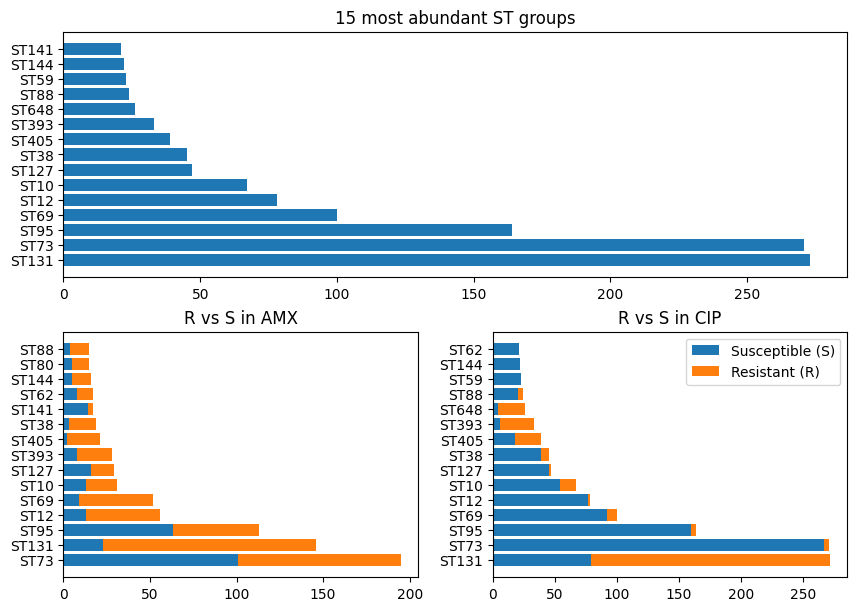

In [7]:
# Data for overall ST groups in data
bplotdata = metadata['MLST'].value_counts().sort_values(ascending = False).head(15)

# Data for AMX ST groups plot
df = metadata[['MLST', 'AMX']].dropna()
df_encoded = pd.get_dummies(df , columns=['AMX'],  dtype=int)
AMX_bardata = df_encoded.groupby("MLST", as_index=False).sum()
AMX_bardata['Total'] = AMX_bardata['AMX_R'] + AMX_bardata['AMX_S']
AMX_bardata = AMX_bardata.sort_values(by="Total", ascending=False).drop(columns="Total").head(15)

# Data for CIP ST groups plot
df = metadata[['MLST', 'CIP']].dropna()
df_encoded = pd.get_dummies(df , columns=['CIP'],  dtype=int)
CIP_bardata = df_encoded.groupby("MLST", as_index=False).sum()
CIP_bardata['Total'] = CIP_bardata['CIP_R'] + CIP_bardata['CIP_S']
CIP_bardata = CIP_bardata.sort_values(by="Total", ascending=False).drop(columns="Total").head(15)

# Creating 3 barplots plots
plt.figure(figsize=(12, 6), layout ='constrained')

ax1 = plt.subplot(2,3,(1,2))
ax1.barh(width = bplotdata, y= bplotdata.index)
ax1.set_title("15 most abundant ST groups")

ax2 = plt.subplot(2,3,4)
ax2.barh(width = AMX_bardata["AMX_S"], y=AMX_bardata["MLST"], label='Susceptible (S)')
ax2.barh(width = AMX_bardata["AMX_R"], left=AMX_bardata["AMX_S"], y=AMX_bardata["MLST"], label='Resistant (R)')
ax2.set_title("R vs S in AMX")

ax3 = plt.subplot(2,3,5)
ax3.barh(width = CIP_bardata["CIP_S"], y=CIP_bardata["MLST"], label='Susceptible (S)')
ax3.barh(width = CIP_bardata["CIP_R"], left=CIP_bardata["CIP_S"], y=CIP_bardata["MLST"], label='Resistant (R)')
ax3.set_title("R vs S in CIP")
ax3.legend()

From the 3 barcharts we can observe that:

- **TOP:** The 15 most abundant ST groups in our dataset. We can see that by a fairly large margin ST73 and ST131 are the most abundant ones, followed by ST95.

- **LOWER LEFT:** The 15 most abundant ST groups just for AMX antibiotic with resistance profiles. We can see that there is overall more resistant strains.

- **LOWER RIGHT:** The 15 most abundant ST groups just for CIP antibiotic with resistance profiles. We can see that there is overall more susceptible strains.

The set of figures illustrates that resistance profiles vary between antibiotic drugs, since there seems to be in general more data of resistant strains in AMX
than for CIP. However and interesting observation is that for both antibiotic drugs, ST131 seems to contain more resistant strains than susceptible ones.

**NOTE:** When we use ML methods and DNA sequences, there is a concern that the method may learn to recognize related isolates. The ML predictions may then be right but simply because highly related  isolates were present in the training and the test dataset.
To make sure this doesn’t happen, we can make sure that all samples from some ST groups are put in either training or in validation data, but not both (blocking).
Different researchers take different approaches to do this and we expect that in the future a standard will emerge. For now, this tutorial provides code to perform block design based on Sequence Types.  

#### **a.2) Year of Isolation:**


The year of isolation refers to when the sample was collected. Resistance patterns can vary not just between different drugs but also across time. Below we can make some barcharts showing the resistance patterns for different antibiotics through the years of isolation. The data was collected from 1970 to 2017.

In [8]:
# Creating a list of all the antibiotic drugs used to test for resistant profiles
druglist = list(metadata.drop(columns=["Isolate", "Lane.accession","MLST", "Year"]).columns)
print(druglist)

['CTZ', 'CTX', 'AMP', 'AMX', 'AMC', 'TZP', 'CXM', 'CET', 'GEN', 'TBM', 'TMP', 'CIP']


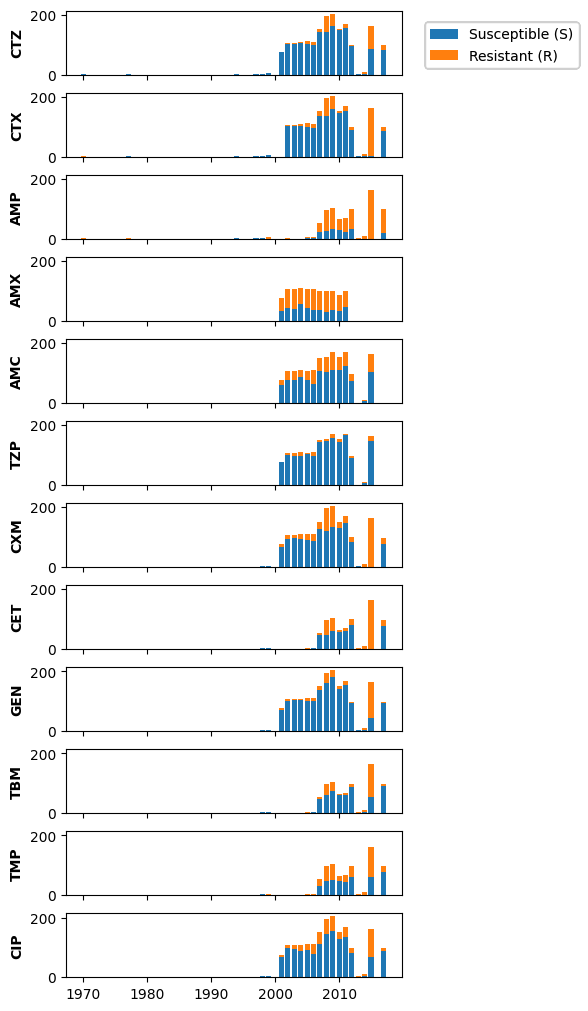

In [9]:
# Plotting graph to let us know if the samples for each drug were collected relatively equally across years in terms of resistant profiles
df = metadata.drop(columns=["Isolate", "Lane.accession","MLST"])
df_encoded = pd.get_dummies(df, columns= df.drop(columns=["Year"]).columns, dtype=int)
data = df_encoded.groupby("Year",as_index=False ).sum()

# plotting data acquisition for each drug across years
fig, ax = plt.subplots(ncols=1, nrows=12, figsize=(4,10), sharey=True, sharex=True, layout="constrained")

for d in druglist:
  ax[druglist.index(d)].bar(data["Year"], data[d +"_S"], label="Susceptible (S)")
  ax[druglist.index(d)].bar(data["Year"], data[d +"_R"], bottom=data[d +"_S"], label="Resistant (R)")
  ax[druglist.index(d)].set_ylabel(d, fontweight ='bold')
  handles, labels = ax[druglist.index(d)].get_legend_handles_labels()
  fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.45, 0.99))


- The graph shows that although we have data on isolates dated all the way throught 1970's, really most of the collection happened more recently in the 2000's.
- We can also see that not all drugs have the same resistance profile, noticeably we see that Resistance is fairly common for AMX and AMP in this data, but a rarity for the rest of the drugs. For AMX the distribution of R vs S seems to have kept the same across years of isolation.

- In addition for CTX, AMP, CXM, CET there seems to have more resistant strains on the later years of collection around 2015's. It is unclear whether this was random or perhaps an attempt to get more Resistant strains in general, to counterbalance the generally dominant presence of Susceptible strains in our dataset.

These observations overall, could mean that Year of isolation could be an important predictor of resistance for some of the drugs at least.

#### **a.3) Determination of Resistant(R) and Susceptible(S) labels per Antibiotic Drug:**

Below we can see a Summary chart of all the antibiotics within our analysis:

|Abreviation|Class: Subclass|Full name|
|:----------|:--------------|:--------|
|**CTZ**|Beta-lactams: Cephalosporins|Ceftazidime|
|**CTX**|Beta-lactams: Cephalosporins|Cefotaxime |
|**CXM**|Beta-lactams: Cephalosporins|Cefuroxime|
|**CET**|Beta-lactams: Cephalosporins|Cephalothin|
|**AMP**|Beta-lactams: Penicillin|Ampicillin|
|**AMX**|Beta-lactams: Penicillin|Amoxicillin|
|**AMC**|Beta-lactams: Penicillin|Amoxicillin + Clavulanate potassium|
|**TZP**|Beta-lactams: Piperacillin|Tazobactam|
|**GEN**|Aminoglycosides|Gentamicin|
|**TBM**|Aminoglycosides|Tobramycin|
|**TMP**|Antifolate|Trimethoprim|
|**CIP**|Fluoroquinolones|Ciprofloxacin|

- **Antimicrobial Susceptibility Testing**:
Laboratory test where a bacterial isolate is grown in the presence of different concentrations of a drug to determine whether it is Susceptible(S), Intermediate (I) or Resistance(R).

- **Clinical Breakpoints**: Each of the drugs listed in the chart have a different concentration (clinical breakpoint) used to determine the Susceptibility or Resistance of *E. coli* to that drug. If the bacterium can grow at a drug concentration higher than the breakpoint, it is considered resistant.

- Results from the laboratory tests were determined based on the guidelines from the [European Committee on Antimicrobial Susceptibility Testing (EUCAST)](https://www.eucast.org/videos_and_online_seminars/english) on 25/01/2017. Click on the link to see a series of videos on how the laboratory tests are done.

- In Moragadivand's paper, isolates that were classified as Intermediate(I) were lumped together with the Resistant ones, therefore we are going to do the same in this tutorial.

Below we can also make a graph of whether isolates for different antibiotics were comming from the same of different ST groups.


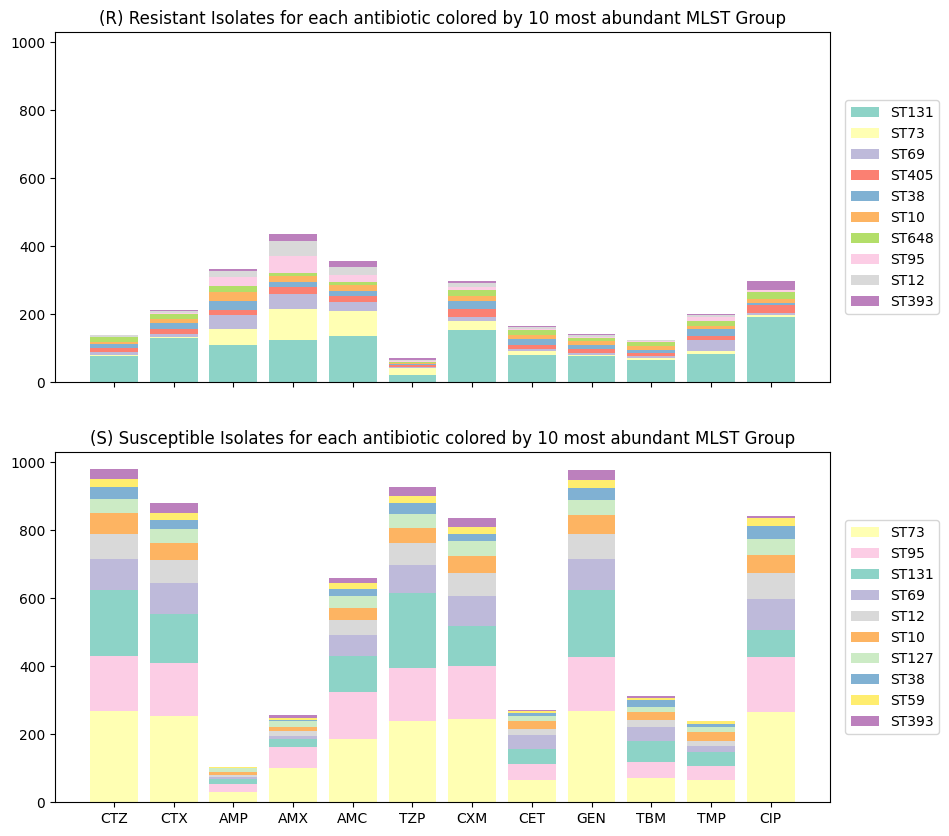

In [10]:
# Plotting graph to let us know if the samples for each drug were collected relatively equally across years
df = metadata.drop(columns=["Isolate", "Lane.accession","Year"])
df_encoded = pd.get_dummies(df, columns= df.drop(columns=["MLST"]).columns, dtype=int)
data = df_encoded.groupby("MLST",as_index=False ).sum()

# Resistant Data
R_drugs = data.drop(columns = ["CTZ_S", "CTX_S", "AMP_S", "AMX_S", "AMC_S", "TZP_S", "CXM_S", "CET_S", "GEN_S", "TBM_S", "TMP_S", "CIP_S"])
R_drugs["Total"]= R_drugs[list(R_drugs.drop(columns=['MLST']).columns)].sum(axis=1)
R_drugs = R_drugs.sort_values(by="Total", ascending=False).reset_index(drop=True).head(10)
R_drugs_array = R_drugs.drop(columns=['MLST', 'Total']).to_numpy()

# Susceptible Data
S_drugs = data.drop(columns = ["CTZ_R", "CTX_R", "AMP_R", "AMX_R", "AMC_R", "TZP_R", "CXM_R", "CET_R", "GEN_R", "TBM_R", "TMP_R", "CIP_R"])
S_drugs["Total"]= S_drugs[list(S_drugs.drop(columns=['MLST']).columns)].sum(axis=1)
S_drugs = S_drugs.sort_values(by="Total", ascending=False).reset_index(drop=True).head(10)
S_drugs_array = S_drugs.drop(columns=['MLST', 'Total']).to_numpy()

# plotting data acquisition for each drug across years
fig, (ax0, ax1) = plt.subplots(ncols=1, nrows=2, figsize=(10, 10), sharex= True, sharey=True)

colors_dic = {"ST131":'#8dd3c7', "ST73":'#ffffb3', "ST69":'#bebada', "ST405":'#fb8072', "ST38": '#80b1d3', "ST10":'#fdb462', "ST648":'#b3de69', "ST95":'#fccde5', "ST12":'#d9d9d9', "ST393":'#bc80bd', "ST127":'#ccebc5', "ST59":'#ffed6f'}
for i in range(R_drugs.shape[0]):
  # Plotting all resistant isolates fro 10 most common ST groups
  ax0.bar(druglist, R_drugs_array[i], bottom = np.sum(R_drugs_array[:i], axis = 0), label = R_drugs['MLST'][i] , color= colors_dic[R_drugs['MLST'][i]])

  ax0.set_title("(R) Resistant Isolates for each antibiotic colored by 10 most abundant MLST Group")
  handles, lab0 = ax0.get_legend_handles_labels()
  ax0.legend(handles, lab0, loc='center right', bbox_to_anchor=(1.15, 0.5))

for i in range(S_drugs.shape[0]):
  ax1.bar(druglist, S_drugs_array[i], bottom = np.sum(S_drugs_array[:i], axis = 0), label = S_drugs['MLST'][i], color=colors_dic[S_drugs['MLST'][i]] )
  ax1.set_title("(S) Susceptible Isolates for each antibiotic colored by 10 most abundant MLST Group")
  handles, lab1 = ax1.get_legend_handles_labels()
  ax1.legend(handles, lab1, loc='center right', bbox_to_anchor=(1.15, 0.5))


- We see that ST73 and ST131 are commonly present in resistant as well as susceptible strains. This means that both of this strains are commonly present in our entire sample. In the paper Moragadigaravand decided to use ST131 to test the machine learning algorythm to see if the model would generalize well if trained in other strains. We on the other hand will use instead Blocked design to test this.
- There is notably more Susceptible data than resistant ones, with the exeptions of AMP and AMX where more Resistant isolates were present.
-  All antibiotic drugs present class imbalance, but the more extreme one is in TZP antibiotic.

**NOTE:** We will learn in subsequent notebooks how to deal with imbalanced datasets as well as controlling for population structure (given as ST groups in this case)

### **B) Gene presence and absence:**

**Genes:** Sequences of DNA that (usually) code for proteins. These sequences can vary in length and the resulting proteins have a variety of functions. Some genes and their resulting proteins are well characterized and have names, whereas others are not well characterized. For our analysis, the genes from our data set will be generally classified into:

- **Core Genome:** These are the genes that are present in almost all individuals for a particular species. In our case, they are the genes that all our *E.coli* isolates have in common. These genes are not present in our dataset because they would be the same for all *E.Coli* samples

- **Accessory Genes:** These are the genes that might be found in one individual but may not be found in another, within the same species. A gene presence / absence table lists which isolates have which genes.

- **Pan-genome:** These are all the possible genes that can be found in a particular species. That is they are all the gene presents present in our *E. coli* isolates (Pan-genome = Core Genome + Accesory Genes).

The code below will show us the dataframe containing the presence and absence of all the genes detected in for each isolate.
- **0** = Absence of the gene
- **1** = Presence of the gene.

**NOTE:** This tutorial focuses on using mainly accessory genes as a predictive factor for R or S, know however that depending on the antibiotic drug and how it interacts with *E. Coli*, there could be Resistant factors that might not be detected at an accesory gene level. For this reason researchers often also use indels (insertion or deletion of particular bases in the genome), SNP (Single Nucleotide Polymorphism, which are changes in a single nucleotide in a string DNA) level as possible predictive features.  



In [11]:
# Visualize the first 5 rows of accessory genes
gene_presence_data.head()

,Unnamed: 0,yeiU,yhhS,ybaE,eutR,ibrB,ytfP,aslB,narQ,tolR,...,group_48768,group_48873,group_48916,group_48933,group_48937,group_48958,group_49020,group_49174,group_49253,group_49257
0,11657_5#1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,11657_5#10,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,11657_5#11,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,11657_5#12,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,11657_5#13,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


Not all genes are well known and have names, therefore the software that creates a gene presence / absence table has separated them in 2 sets of genes that were named differently:

**1) Named genes**: which were extracted from the annotated DNA sequences.

In the code below we can take a look at all the names of the named genes because **they do not have the word "group"** in them.

In [12]:
# this code will output the list of named genes and the length of it
named_genes = [col for col in gene_presence_data.drop(columns=["Unnamed: 0"]).columns if 'group' not in col]
print("List of named_genes:")
print(named_genes)
print("Total number of named genes included: ", len(named_genes))

List of named_genes:
['yeiU', 'yhhS', 'ybaE', 'eutR', 'ibrB', 'ytfP', 'aslB', 'narQ', 'tolR', 'galM', 'modB', 'pgl', 'glnQ', 'ydjM', 'osmE', 'rcsF', 'fruB', 'rsuA', 'yfcA', 'ypfN', 'pdxJ', 'plsX', 'ycfF', 'minD', 'marC_2', 'sugE', 'psd', 'nsrR', 'rnfA', 'kbl', 'greB', 'mgsA', 'mukE', 'dtd', 'cpxP', 'fbp', 'luxS', 'fldB', 'epd', 'phoR', 'adk', 'ybbN', 'ilvM', 'ilvE', 'fre', 'glmM', 'gpt', 'aaeX', 'ygcM', 'rplS', 'raiA', 'cvrA', 'hflC_2', 'mgtA', 'speC_2', 'yfeK', 'fsr', 'trmA', 'cmr', 'yceL', 'flgE', 'narG', 'ptsA', 'dmlR_6', 'mutS', 'ybgC', 'moaC', 'artM_1', 'agp', 'sdaA', 'ruvC', 'pgsA', 'yecF', 'yaeT', 'ftsQ', 'ksgA', 'ytjA', 'sanA', 'ccmG', 'nuoK', 'suhB', 'yfiD', 'rpmF', 'fabG_3', 'lolD_2', 'prfA', 'frdC', 'ftsE', 'ycaR', 'cmk', 'fepC', 'ftsB', 'hypA', 'xerD_1', 'rsmE', 'xseB', 'ybaZ', 'ybaB', 'ptsN', 'yeeX', 'yhbP', 'gmr_1', 'sgrR', 'poxB', 'putA', 'clpA', 'ypdC_1', 'pdxK', 'folM', 'ugpB', 'astA', 'yeiA', 'flgK', 'rne', 'chaA', 'mobB', 'ebgA', 'allS_1', 'chaC', 'pdxY', 'yciH', 'rf

**2) Unnamed genes**: these are the DNA sequences that look like a gene (e.g., they have a start and a stop codon) and are grouped based on **orthologous gene groups**. This means that these are sequences where we don't necessarily know their function, but we know that they exist in many of the *E. coli* isolates, **they get a name that starts with "group"**.

**NOTE: Orthologous genes**: are genes that derive from the same ancestral gene.





In [13]:
# this code will output all the genes without an assigned gene name.
other_genes = [col for col in gene_presence_data.drop(columns=["Unnamed: 0"]).columns if 'group' in col]
print("List of unnamed genes:")
print(other_genes)
print("Total number of unnamed genes included: ", len(other_genes))

List of unnamed genes:
['group_1150', 'group_16546', 'group_2705', 'group_3304', 'group_4923', 'group_4964', 'group_5584', 'group_8156', 'group_8252', 'group_149', 'group_2086', 'group_4319', 'group_5721', 'group_6765', 'group_6877', 'group_698', 'group_8153', 'group_16576', 'group_2284', 'group_6886', 'group_8258', 'group_944', 'group_11031', 'group_1129', 'group_1555', 'group_16561', 'group_2491', 'group_5642', 'group_6779', 'group_776', 'group_10930', 'group_2199', 'group_2731', 'group_4247', 'group_4302', 'group_1533', 'group_1556', 'group_2333', 'group_2498', 'group_2757', 'group_3978', 'group_781', 'group_817', 'group_1153', 'group_1304', 'group_1320', 'group_3797', 'group_6621', 'group_4315', 'group_1139', 'group_4791', 'group_1752', 'group_2311', 'group_3038', 'group_3099', 'group_3784', 'group_4906', 'group_6713', 'group_6771', 'group_1132', 'group_6802', 'group_10939', 'group_1390', 'group_472', 'group_3791', 'group_1518', 'group_3896', 'group_1558', 'group_137', 'group_3451'

**NOTE:** The code below is showing us which Isolates have the ortholog gene group called **"group_13605"** In this case we have 8 isolates that have this gene.

In [14]:
# the code below prints all the isolate numbers that have a 1 (presence) for a particular group
print(gene_presence_data[gene_presence_data["group_13605" ]== 1]["Unnamed: 0"])

222      11657_7#39
895      11679_4#73
922      11679_5#10
1066     11679_6#56
1739    24742_1#155
1881    24742_1#295
1883    24742_1#297
1912    24742_1#324
Name: Unnamed: 0, dtype: object


The code below can show us the shape of our entire dataframe in the following format: **(Row count, Column count)**

**a) Row count**: Notice that the number of isolates is 2033, whereas in the Metadata file there were only 1936. We can only work with isolates for which we have metadata, so later on we will filter out the ones that do not have a corresponding metadata.

**b) Column count**: The number of columns is 17199 = Isolate number(1) + named_genes(3815) + unnamed_genes(13383)

In [15]:
# Observe the shape and size of the dataframe
gene_presence_data.shape

(2033, 17199)

## **3) Final dataset used in subsequent notebooks**

#### **a)** Making a single dataframe using both data sources

**Notes:**
- **lambda** is an expression used to create python functions without needing to name them specifically, in this case we are asking to merge our dataframes from left to right, so metadata_d first and then gene_presence_data.
- **reduce** is a function that allow us to repeat a particular function on a list of objects. This was done because the merge function only takes 2 dataframes at the time. This way you can include as many dataframes you want to merge in our **df_list** in case you want to work with more features.
- The function **merge()**, allows to pass the parameter **(on ="Isolate")**, which will ensure that each isolate number is correctly matched for both data sources, the parameter **(how="inner")** will make sure that isolates without a match are not included in the final dataframe.

In [16]:
# matching the Isolate column name for both datasets
gene_presence_data.rename(columns={'Unnamed: 0': 'Isolate'}, inplace=True)

# List of data sources
df_list = [metadata,gene_presence_data]

# creating a single dataframe with all drugs and features available
Drug_df = reduce(lambda  left,right: pd.merge(left,right,on=['Isolate'], how='inner'), df_list)
Drug_df.head()


,Lane.accession,MLST,Isolate,Year,CTZ,CTX,AMP,AMX,AMC,TZP,...,group_48768,group_48873,group_48916,group_48933,group_48937,group_48958,group_49020,group_49174,group_49253,group_49257
0,ERR435312,ST68,11679_6#21,2001.0,S,NaN,NaN,S,S,S,...,0,0,0,0,0,0,0,0,0,0
1,ERR434919,ST652,11658_6#85,2005.0,S,S,NaN,S,S,S,...,0,0,0,0,0,0,0,0,0,0
2,ERR434399,ST95,11657_6#45,2005.0,S,S,NaN,R,R,R,...,0,0,0,0,0,0,0,0,0,0
3,ERR434695,ST73,11658_4#53,2005.0,S,S,NaN,R,S,S,...,0,0,0,0,0,0,0,0,0,0
4,ERR434696,ST73,11658_4#54,2005.0,S,S,NaN,R,S,S,...,0,0,0,0,0,0,0,0,0,0


#### **b)** Deleting Lane.accession number

Because Lane.Ascession and Isolate number are both forms of to identify the same observation we can eliminate Lane.Ascession as it will not be useful to the models we want to create.

In [17]:
# Deleting Ascension number
Drug_df.drop(columns=["Lane.accession"], axis=1, inplace=True)
Drug_df.head()

,MLST,Isolate,Year,CTZ,CTX,AMP,AMX,AMC,TZP,CXM,...,group_48768,group_48873,group_48916,group_48933,group_48937,group_48958,group_49020,group_49174,group_49253,group_49257
0,ST68,11679_6#21,2001.0,S,NaN,NaN,S,S,S,R,...,0,0,0,0,0,0,0,0,0,0
1,ST652,11658_6#85,2005.0,S,S,NaN,S,S,S,S,...,0,0,0,0,0,0,0,0,0,0
2,ST95,11657_6#45,2005.0,S,S,NaN,R,R,R,S,...,0,0,0,0,0,0,0,0,0,0
3,ST73,11658_4#53,2005.0,S,S,NaN,R,S,S,S,...,0,0,0,0,0,0,0,0,0,0
4,ST73,11658_4#54,2005.0,S,S,NaN,R,S,S,S,...,0,0,0,0,0,0,0,0,0,0


- Notice that the number of rows is now correctly matched with Isolate number, yielding a total of 1936 rows as in the metadata.

- Also we now have a bunch of columns that currently include:
  - **1 MLST column** this column could be used to as a blocking factor
  - **1 isolate column** these are the unique tags for each of our isolates.
  - **12 labels**, one for each drug we will try to make predictions for.
  - **1 Year column** this column corresponds to the isolation year
  - **17198 features** that we will be using to make prediction for the labels (isolation year and gene presence or absence).


In [18]:
# Check out all the columns included in the final dataframe and the final shape it takes
print(Drug_df.columns) # contains all labels (drug abreviation column names)
                       # and all features (year, gene presence absence and population structure)

print("Final shape of combined dataframe",Drug_df.shape)

Index(['MLST', 'Isolate', 'Year', 'CTZ', 'CTX', 'AMP', 'AMX', 'AMC', 'TZP',
       'CXM',
       ...
       'group_48768', 'group_48873', 'group_48916', 'group_48933',
       'group_48937', 'group_48958', 'group_49020', 'group_49174',
       'group_49253', 'group_49257'],
      dtype='object', length=17213)
Final shape of combined dataframe (1936, 17213)


#### **c)** Convert the Dataframe into a CSV and save it in a folder

After running the code below, feel free to check your Drive to make sure that you have a folder named **"EColi_ML_CSV_files"** and that inside you have a csv called **"EColi_Merged_dfs.csv"**


In [19]:
# Note that if you have already done this – you will just get an output that this directory or file already exists.
# If you want the code to run again, delete the EColi_ML_CSV_files folder and/or EColi_Merged_df.csv file in your Drive.

try:
  # makes a directory to save all your csv's
  os.mkdir('/content/drive/My Drive/EColi_ML_CSV_files')

  # path where we will store csv data #change to any path you want
  path = '/content/drive/My Drive/EColi_ML_CSV_files/'

  # this code exports the dataframe into a CSV file
  Drug_df.to_csv(path+"EColi_Merged_df.csv", index= False)

except:
  print("Directory and file have already been created")

Directory and file have already been created


CONGRATULATIONS on making it this far! Now that our data is ready, we will learn how to create and train different Machine Learning models based on the csv file we just created. In the next notebook, we will learn about our first model for this tutorial series, [Logistic Regression](https://github.com/Lucy-Moctezuma/Machine-Learning-Projects-for-SFSU/blob/main/E.%20Coli%20Machine%20Learning%20Project/2_Logistic_Regression_LR.ipynb).